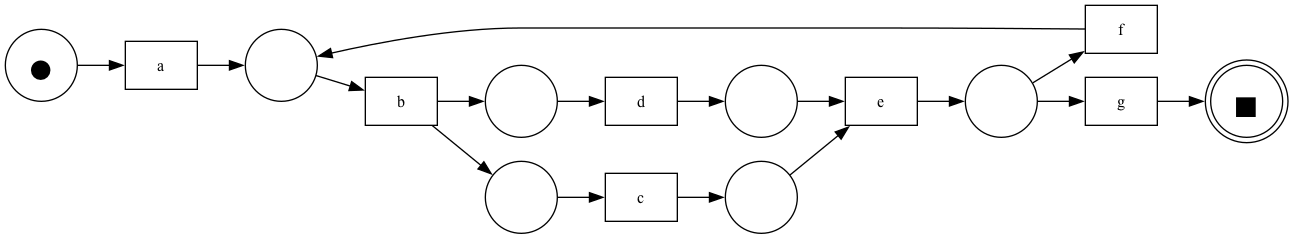

Petri net saved to alpha_petri_net.svg
Reachability graph: 8 states, 9 edges
Final states (matching fm): [7]
0 --a--> 1
1 --b--> 2
2 --c--> 3
2 --d--> 4
3 --d--> 5
4 --c--> 5
5 --e--> 6
6 --f--> 1
6 --g--> 7


/var/folders/27/h86gj_fd3xg23kmxw_95c6kc0000gn/T/ipykernel_3991/298507789.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Reachability graph saved to reachability_graph.png


In [1]:
from pm4py.objects.log.obj import EventLog, Trace, Event

# Your log L:
traces = [
    ['a','b','c','d','e','f','b','d','c','e','g'],
    ['a','b','d','c','e','g'],
    ['a','b','c','d','e','f','b','c','d','e','f','b','d','c','e','g']
]

log = EventLog()
for seq in traces:
    tr = Trace()
    for act in seq:
        tr.append(Event({"concept:name": act}))
    log.append(tr)

# --- 2) Alpha Miner → Petri net ----------------------------------------------
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_vis

net, im, fm = alpha_miner.apply(log)

# Save a diagram of the Petri net (SVG/PNG)
gviz = pn_vis.apply(net, im, fm)
# pn_vis.save(gviz, "alpha_petri_net.svg")
pn_vis.view(gviz)  # This will open the Petri net in a viewer
print("Petri net saved to alpha_petri_net.svg")

# --- 3) Reachability graph (state space) --------------------------------------
# We'll compute it directly using Petri net firing semantics.
from pm4py.objects.petri_net.semantics import enabled_transitions, execute
from collections import deque

def serialize_marking(marking):
    # Turn a Marking into a hashable, readable tuple of (place_name, tokens)
    return tuple(sorted((p.name, marking[p]) for p in marking if marking[p] > 0))

def compute_reachability_graph(net, initial_marking, max_states=10000):
    queue = deque([initial_marking])
    key0 = serialize_marking(initial_marking)
    id_of = {key0: 0}               # serialized_marking -> node id
    marking_of = {0: initial_marking}  # node id -> Marking
    edges = []                      # (src_id, dst_id, transition_label)

    while queue and len(id_of) < max_states:
        m = queue.popleft()
        mid = id_of[serialize_marking(m)]
        for t in enabled_transitions(net, m):
            m2 = execute(t, net, m)
            k2 = serialize_marking(m2)
            if k2 not in id_of:
                nid = len(id_of)
                id_of[k2] = nid
                marking_of[nid] = m2
                queue.append(m2)
            else:
                nid = id_of[k2]
            label = t.label if t.label is not None else t.name
            edges.append((mid, nid, label))
    return id_of, marking_of, edges

id_of, marking_of, edges = compute_reachability_graph(net, im)

# Identify which states are final (equal to fm)
final_key = serialize_marking(fm)
final_states = [nid for k, nid in id_of.items() if k == final_key]

print(f"Reachability graph: {len(marking_of)} states, {len(edges)} edges")
print(f"Final states (matching fm): {final_states}")

# Print a few edges (src -> dst : transition)
for (u, v, lbl) in edges[:25]:
    print(f"{u} --{lbl}--> {v}")

# --- (Optional) Draw the reachability graph with NetworkX/Matplotlib ----------
#   Note: can get large; this is just a quick visualization.
try:
    import networkx as nx
    import matplotlib.pyplot as plt

    G = nx.DiGraph()
    for nid, m in marking_of.items():
        G.add_node(nid, label=str(serialize_marking(m)))
    for (u, v, lbl) in edges:
        G.add_edge(u, v, label=lbl)

    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=800, font_size=8)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
    plt.tight_layout()
    plt.savefig("reachability_graph.png", dpi=200)
    plt.close()
    print("Reachability graph saved to reachability_graph.png")
except Exception as e:
    print("Skipping reachability graph drawing (optional). Reason:", e)


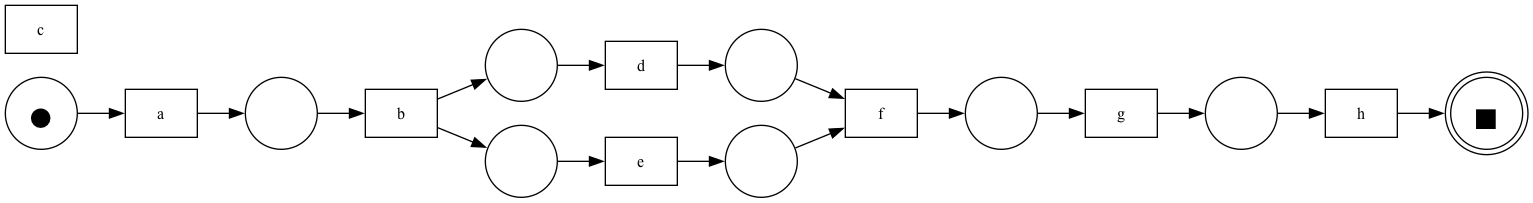

Places: 9 Transitions: 8
Initial marking: {'start': 1}
Final marking: {'end': 1}


In [2]:
# --- Build the event log ---
from pm4py.objects.log.obj import EventLog, Trace, Event

traces = [
    ['a','b','c','d','e','f','g','h'],              # 1
    ['a','b','d','c','c','e','f','g','h'],          # 2
    ['a','b','e','d','c','f','g','h'],              # 3
    ['a','b','c','c','e','d','f','g','h'],          # 4
    ['a','b','e','c','d','f','g','h']               # 5
]

log = EventLog()
for seq in traces:
    tr = Trace()
    for act in seq:
        tr.append(Event({"concept:name": act}))
    log.append(tr)

# --- Alpha miner → Petri net ---
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_vis

net, im, fm = alpha_miner.apply(log)

# --- Visualize & save (SVG/PNG) ---
gviz = pn_vis.apply(net, im, fm)          # uses Graphviz via pydot

# visualize the Petri net
pn_vis.view(gviz)  # This will open the Petri net in a viewer

# (optional) print a quick summary
print("Places:", len(net.places), "Transitions:", len(net.transitions))
print("Initial marking:", {p.name: im[p] for p in im})
print("Final marking:",   {p.name: fm[p] for p in fm})


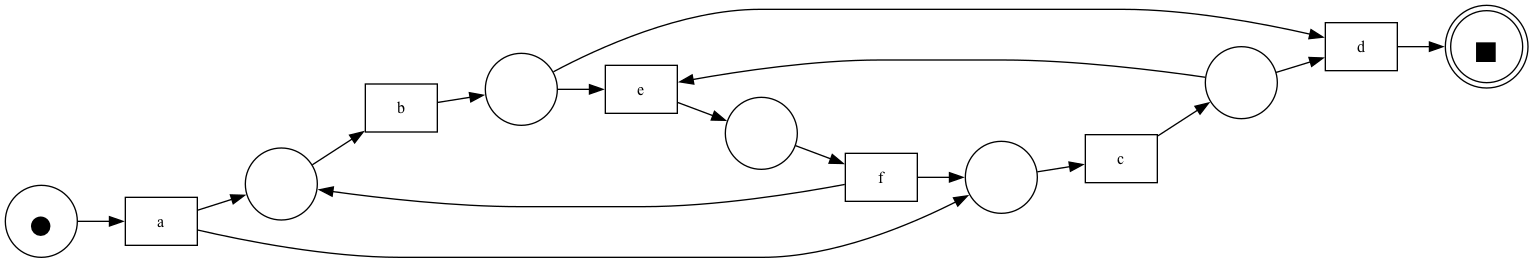

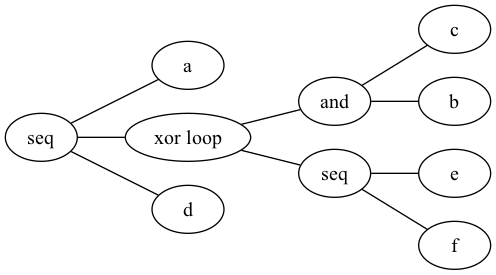

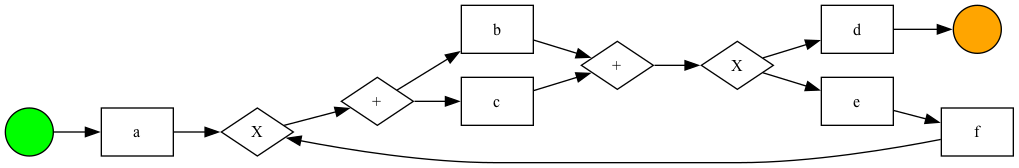

Petri places: 7 transitions: 6
Initial marking: {'start': 1}
Final marking: {'end': 1}


In [7]:
# ===== 0) Imports =====
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_vis
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.bpmn import visualizer as bpmn_vis
from pm4py.visualization.process_tree import visualizer as pt_vis

# ===== 1) Build L2 (expand powers) =====
# L2 = [ <a,b,c,d>^3, <a,c,b,d>^4, <a,b,c,e,f,b,c,d>^2, <a,b,c,e,f,c,b,d>,
#        <a,c,b,e,f,b,c,d>^2, <a,c,b,e,f,b,c,e,f,c,b,d> ]

seq1 = ['a','b','c','d']
seq2 = ['a','c','b','d']
seq3 = ['a','b','c','e','f','b','c','d']
seq4 = ['a','b','c','e','f','c','b','d']
seq5 = ['a','c','b','e','f','b','c','d']
seq6 = ['a','c','b','e','f','b','c','e','f','c','b','d']

traces = []
traces += [seq1]
traces += [seq2]
traces += [seq3]
traces += [seq4]
traces += [seq5]
traces += [seq6]

# PM4Py EventLog
log = EventLog()
for seq in traces:
    tr = Trace()
    for act in seq:
        tr.append(Event({"concept:name": act}))
    log.append(tr)

# ===== 2) Petri net via Alpha Miner =====
net, im, fm = alpha_miner.apply(log)
pn_gviz = pn_vis.apply(net, im, fm)          # Graphviz render
pn_vis.view(pn_gviz)  # This will open the Petri net in a viewer

# ===== 3) BPMN via Inductive Miner → Process Tree → BPMN =====
pt = inductive_miner.apply(log)               # discover process tree

pt_gviz = pt_vis.apply(pt)
pt_vis.view(pt_gviz)  # This will open the process tree in a viewer
bpmn = pt_converter.apply(pt, variant=pt_converter.Variants.TO_BPMN)
bpmn_gviz = bpmn_vis.apply(bpmn)
bpmn_vis.view(bpmn_gviz)  # This will open the BPMN in a viewer

# (optional) quick stats
print("Petri places:", len(net.places), "transitions:", len(net.transitions))
print("Initial marking:", {p.name: im[p] for p in im})
print("Final marking:",   {p.name: fm[p] for p in fm})






In [8]:
# ===== 0) Imports =====
from pm4py.objects.log.obj import EventLog, Trace, Event
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.visualization.petri_net import visualizer as pn_vis
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as pt_converter
from pm4py.visualization.bpmn import visualizer as bpmn_vis
from pm4py.visualization.process_tree import visualizer as pt_vis
from pm4py.objects.process_tree.obj import ProcessTree, Operator

# ===== 1) Build L2 (expand powers) =====
seq1 = ['a','b','c','d']
seq2 = ['a','c','b','d']
seq3 = ['a','b','c','e','f','b','c','d']
seq4 = ['a','b','c','e','f','c','b','d']
seq5 = ['a','c','b','e','f','b','c','d']
seq6 = ['a','c','b','e','f','b','c','e','f','c','b','d']

traces = []
traces += [seq1]
traces += [seq2]
traces += [seq3]
traces += [seq4]
traces += [seq5]
traces += [seq6]

log = EventLog()
for seq in traces:
    tr = Trace()
    for act in seq:
        tr.append(Event({"concept:name": act}))
    log.append(tr)

# ===== 2) Petri net via Alpha Miner =====
net, im, fm = alpha_miner.apply(log)
pn_gviz = pn_vis.apply(net, im, fm)
pn_vis.save(pn_gviz, "petri_net.svg")
print("Saved: petri_net.svg")

# ===== 3) Inductive Miner → original process tree (for reference) =====
pt_orig = inductive_miner.apply(log)
pt_orig_gviz = pt_vis.apply(pt_orig)
pt_vis.save(pt_orig_gviz, "process_tree_original.svg")
print("Saved: process_tree_original.svg")

# ===== 4) Helper: clone & remove loops from a process tree =====
def clone_without_loops(node, mode="once"):
    """
    Create a copy of 'node' with NO Operator.LOOP.
    Modes:
      - "once": LOOP(body, redo, exit)  ->  SEQUENCE( body , exit )
               (execute body exactly once, then exit)
      - "optional_once": -> SEQUENCE( XOR(tau, body) , exit )
               (execute body 0 or 1 time, then exit)
    """
    if node is None:
        return None

    # Leaf
    if node.operator is None:
        return ProcessTree(label=node.label)

    # Non-loop operators: clone and recurse
    if node.operator != Operator.LOOP:
        new_node = ProcessTree(operator=node.operator)
        for ch in node.children:
            child_clone = clone_without_loops(ch, mode)
            child_clone.parent = new_node
            new_node.children.append(child_clone)
        return new_node

    # Loop operator: replace according to selected mode
    body = clone_without_loops(node.children[0], mode)
    exit_part = clone_without_loops(node.children[2], mode)

    if mode == "optional_once":
        # XOR(tau, body)
        tau = ProcessTree(label=None)  # τ (silent)
        xor_node = ProcessTree(operator=Operator.XOR)
        tau.parent = xor_node
        body.parent = xor_node
        xor_node.children = [tau, body]

        seq = ProcessTree(operator=Operator.SEQUENCE)
        xor_node.parent = seq
        exit_part.parent = seq
        seq.children = [xor_node, exit_part]
        return seq

    # Default: "once" (at least once, no repetition)
    seq = ProcessTree(operator=Operator.SEQUENCE)
    body.parent = seq
    exit_part.parent = seq
    seq.children = [body, exit_part]
    return seq

# Choose the behavior you want for loops:
#   "once"           -> do the loop body exactly once
#   "optional_once"  -> allow skipping the loop body entirely
pt_no_loops = clone_without_loops(pt_orig, mode="once")

# (Sanity) visualize loop-free process tree
pt_noloop_gviz = pt_vis.apply(pt_no_loops)
pt_vis.save(pt_noloop_gviz, "process_tree_no_loops.svg")
print("Saved: process_tree_no_loops.svg")

# ===== 5) Convert the loop-free tree to BPMN and visualize =====
bpmn = pt_converter.apply(pt_no_loops, variant=pt_converter.Variants.TO_BPMN)
bpmn_gviz = bpmn_vis.apply(bpmn)
bpmn_vis.save(bpmn_gviz, "bpmn_no_loops.svg")
print("Saved: bpmn_no_loops.svg")

# (optional) quick stats
print("Petri places:", len(net.places), "Transitions:", len(net.transitions))
print("Initial marking:", {p.name: im[p] for p in im})
print("Final marking:",   {p.name: fm[p] for p in fm})


Saved: petri_net.svg
Saved: process_tree_original.svg


IndexError: list index out of range